Deep Learning
=============

Here we attempt to load, explore and clean if required the data from street view housing numbers dataset. 

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from scipy import io
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [7]:
train = io.loadmat('train_32x32.mat')
test = io.loadmat('test_32x32.mat')
train_dataset, train_labels = train['X'], train['y']
test_dataset, test_labels = test['X'], test['y']
print("Training: X: {} y: {}".format(train_dataset.shape, train_labels.shape))
print("Test: X: {} y: {}".format(test_dataset.shape, test_labels.shape))
#print("Converting to gray scale and reshaping ...")
#train_dataset = train_dataset.mean(axis=2).T.astype(np.float32)
#test_dataset = test_dataset.mean(axis=2).T.astype(np.float32)
print("Reshaping ...")
train_dataset = train_dataset.T.astype(np.float32)
test_dataset = test_dataset.T.astype(np.float32)
train_labels = train_labels.reshape(-1)
test_labels = test_labels.reshape(-1)
print("Training: X: {} y: {}".format(train_dataset.shape, train_labels.shape))
print("Test: X: {} y: {}".format(test_dataset.shape, test_labels.shape))

Training: X: (32, 32, 3, 73257) y: (73257, 1)
Test: X: (32, 32, 3, 26032) y: (26032, 1)
Reshaping ...
Training: X: (73257, 3, 32, 32) y: (73257,)
Test: X: (26032, 3, 32, 32) y: (26032,)


7
10
2
4
1
2
7
5
4
8


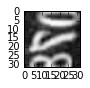

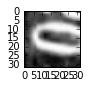

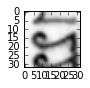

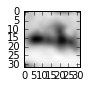

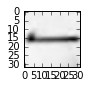

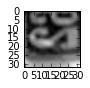

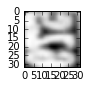

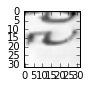

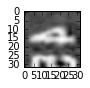

In [4]:
import random
for _ in range(10):
    plt.figure(figsize=(1,1))
    idx = random.randint(0, train_dataset.shape[0])
    print(train_labels[idx])
    plt.imshow(train_dataset[idx], cmap='Greys_r')
plt.close()

#### Unique output classes

In [13]:
output_classes = set(train_labels.flatten()) & set(test_labels.flatten())
print("Output classes: {}".format(','.join(map(str, output_classes))))

Output classes: 1,2,3,4,5,6,7,8,9,10


#### Verify that data is balanced across classes.

In [14]:
from collections import defaultdict
import operator
from functools import partial
counts = defaultdict(int)
for x in train_labels.flatten():
    counts[x] += 1
total = float(len(train_labels.flatten()))
print("Absolute counts of classes")
print(zip(counts.keys(), counts.values()))
print("Per class distributions:")
print(zip(counts.keys(), map(partial(operator.mul, 100/total), counts.values())))

Absolute counts of classes
[(1, 13861), (2, 10585), (3, 8497), (4, 7458), (5, 6882), (6, 5727), (7, 5595), (8, 5045), (9, 4659), (10, 4948)]
Per class distributions:
[(1, 18.921058738414075), (2, 14.449131141051367), (3, 11.598891573501508), (4, 10.18059707604734), (5, 9.394324091895655), (6, 7.817682951799828), (7, 7.637495392931734), (8, 6.886713897648006), (9, 6.359801793685245), (10, 6.7543033430252395)]


Data doesn't look balanced across classes. Let's try to have equal proportions of samples across classes. 

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [5]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

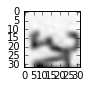

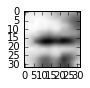

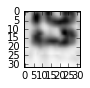

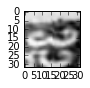

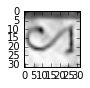

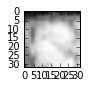

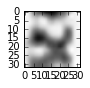

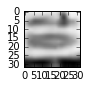

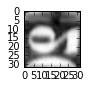

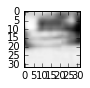

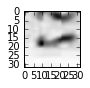

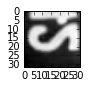

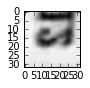

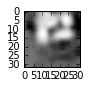

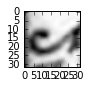

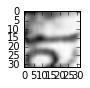

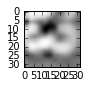

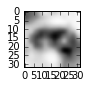

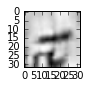

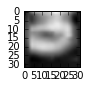

In [20]:
def display_images(dataset):
    for im in dataset[:10, :, :]:
        plt.figure(figsize=(1,1))
        plt.imshow(im, cmap='Greys_r')
display_images(train_dataset)
display_images(test_dataset)

Let's use stratified shuffle split to create the training and validation set. Use 10% of data for validation.

In [8]:
from sklearn.cross_validation import StratifiedShuffleSplit
kf = StratifiedShuffleSplit(train_labels, random_state=0, train_size=0.9)
train_idx, valid_idx = next(iter(kf))
train_dataset_new = train_dataset[train_idx]
train_labels_new = train_labels[train_idx]
valid_dataset = train_dataset[valid_idx]
valid_labels = train_labels[valid_idx]
train_dataset = train_dataset_new
train_labels = train_labels_new

In [9]:
# standardizing the data by subtracting the mean pixel depth 
pixel_depth = 255.0
train_dataset -= pixel_depth/2
train_dataset /= pixel_depth
valid_dataset -= pixel_depth/2
valid_dataset /= pixel_depth
test_dataset -= pixel_depth/2
test_dataset /= pixel_depth

Finally, let's save the data for later reuse:

In [10]:
pickle_file = 'SVHN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [11]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1220162971


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [8]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
print("Length of training data set: {}".format(len(train_idx)))
X_train = train_dataset[train_idx].reshape(-1, 32*32)
y_train = train_labels[train_idx]
lr.fit(X_train, y_train)

Length of training data set: 60000


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
num_test_samples = 20000
X_test = test_dataset[:num_test_samples, :, :].reshape(-1, 32*32)
y_test = test_labels[:num_test_samples]
ypreds = lr.predict(X_test)
print("Score: {}".format(lr.score(X_test, y_test)))

Score: 0.2337
